In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os

#set figure size
plt.rcParams["figure.figsize"] = (13, 7)

In [47]:
rootdir = 'C:/Users/kdorji/Desktop/RMA Data Analysis/2021/'

In [48]:
#Data Cleaning
def clean_data(df, file_name):    
    #Drop unwanted columns
    drop_col = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 3', 'Transaction Report', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', \
                'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17']
    df = df.drop(columns=drop_col)

    #Drop row if BFS TXn Id is NaN
    df = df.dropna(subset=['Unnamed: 2'])

    #Assign Column Headers and exclude the first row
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df = df.rename(columns={'Transaction Amount ':'Transaction Amount'})

    #Set BFS Txn Id and OrderNo as index of df
    df = df.set_index(['BFS Txn Id', 'Order No.'])
    
    #Convert data type of Transaction Amount to numeric
    df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'])
    
    #convert data type of Transaction Date to DateTime
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    
    #Add new column for transaction status
    df['Status'] = file_name.lower()
    
    return df

In [49]:
#Extract data from all files and merge into one Dataframe
def extract_data(file_path):
    dfs = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            #file path
            file_path = os.path.join(subdir, file)
            #extract file name only
            file_name = os.path.splitext(os.path.basename(file_path))[0]
            #read csv file
            this_df = pd.read_csv(file_path)
            this_df = clean_data(this_df, file_name)
            dfs.append(this_df)
    df = pd.concat(dfs)
    return df

In [50]:
df = extract_data(rootdir)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2347890 entries, (124302721901, 1081514) to (124402721911.0, 1081523.0)
Data columns (total 5 columns):
Transaction Date      datetime64[ns]
Beneficiary Bank      object
Remitter Bank         object
Transaction Amount    float64
Status                object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 143.3+ MB


### Remitter Bank Statistics

In [53]:
banks = df.groupby(['Remitter Bank', 'Status'])['Transaction Amount'].agg(['count'])
banks.reset_index(inplace=True)

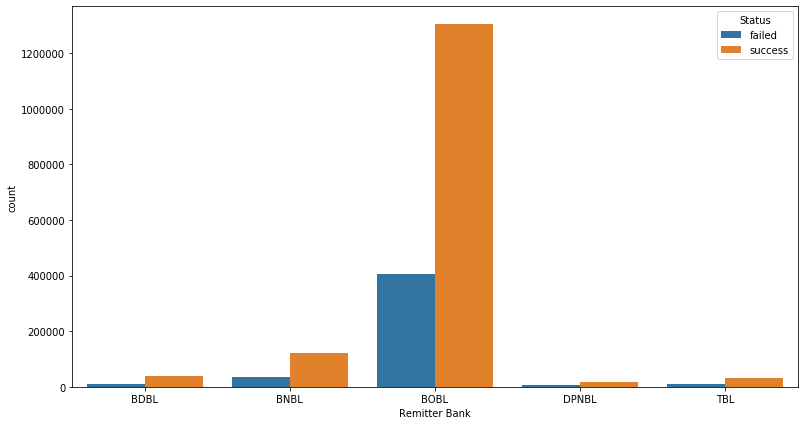

In [54]:
sns.barplot(x='Remitter Bank', y='count', hue='Status', data=banks)
plt.show()

In [55]:
month_banks = df.groupby([df['Transaction Date'].dt.month,'Remitter Bank'])['Transaction Amount'].agg(['count', 'sum', 'mean'])
month_banks.reset_index(inplace=True)
months = month_banks['Transaction Date'].unique().tolist()

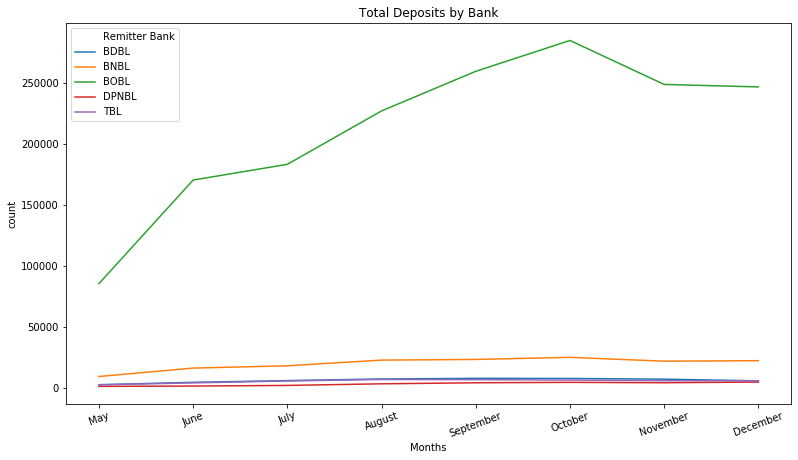

In [99]:
sns.lineplot(x='Transaction Date', y='count', data=month_banks, hue='Remitter Bank')
plt.xticks(months, calendar.month_name[months[0]:months[-1]+1], rotation=20)
plt.xlabel('Months')
plt.title('Total Deposits by Bank')
plt.show()

### Monthly Statistics

In [57]:
month = df.groupby([df['Transaction Date'].dt.month, df['Status']])['Transaction Amount'].agg('count').unstack()

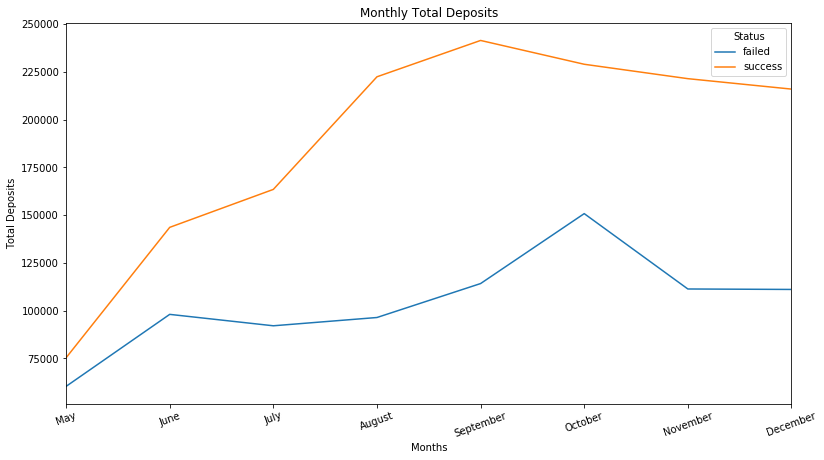

In [98]:
month.plot()
#sns.lineplot(x=month.index, y='count', data=month)
plt.xticks(month.index, calendar.month_name[month.index[0]:month.index[-1]+1], rotation=20)
plt.xlabel('Months')
plt.ylabel('Total Deposits')
plt.title('Monthly Total Deposits')
plt.show()

### Week Day Statistics

In [59]:
day = df.groupby([df['Transaction Date'].dt.dayofweek, df['Status']])['Transaction Amount'].agg(['count'])

In [60]:
day.reset_index(inplace=True)

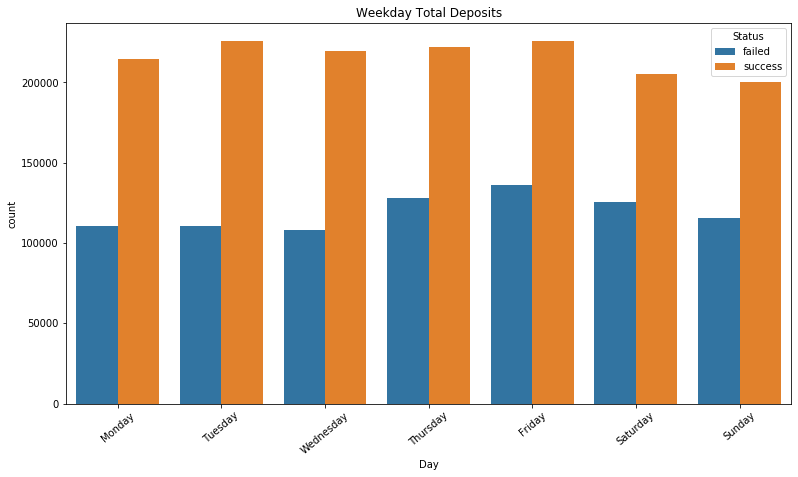

In [96]:
sns.barplot(x='Transaction Date', y='count', hue='Status', data=day)
plt.xticks(np.arange(7), calendar.day_name[0:8], rotation=40)
plt.xlabel('Day')
plt.title('Weekday Total Deposits')
plt.show()

### Hourly Statistics

In [91]:
hour = df.groupby([df['Transaction Date'].dt.hour, df['Status']])['Transaction Amount'].agg('count').unstack()

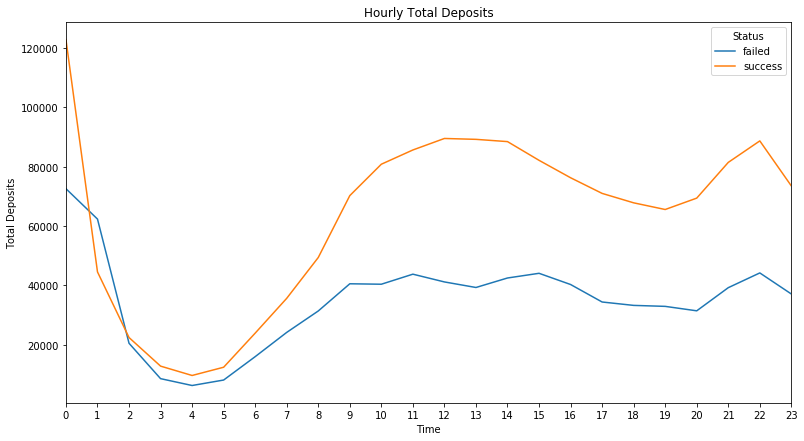

In [97]:
#sns.lineplot(x=hour.index, y='count', data=hour)
hour.plot()
plt.xticks(np.arange(24))
plt.xlabel('Time')
plt.ylabel('Total Deposits')
plt.title('Hourly Total Deposits')
plt.show()

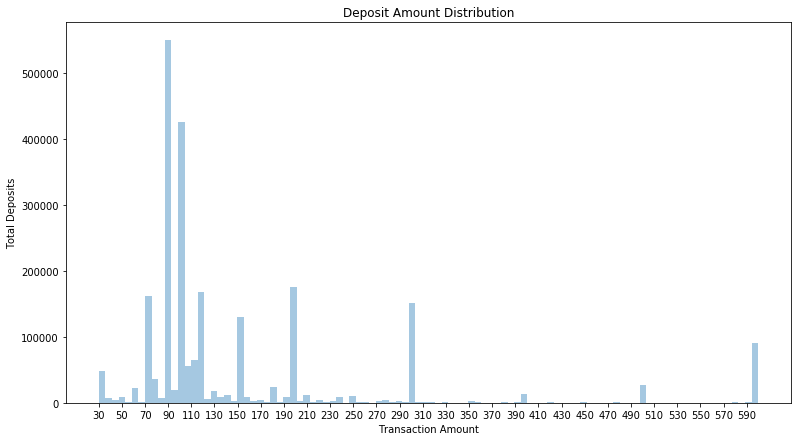

In [93]:
sns.distplot(df['Transaction Amount'], kde=False, bins=100)
plt.xticks(np.arange(30, 601, 20))
plt.title('Deposit Amount Distribution')
plt.ylabel('Total Deposits')
plt.show()

In [126]:
amount = df.groupby(df['Transaction Amount'])['Transaction Amount'].agg('count').sort_values(ascending=False).head(10)

In [143]:
amount.index = amount.index.astype(int)

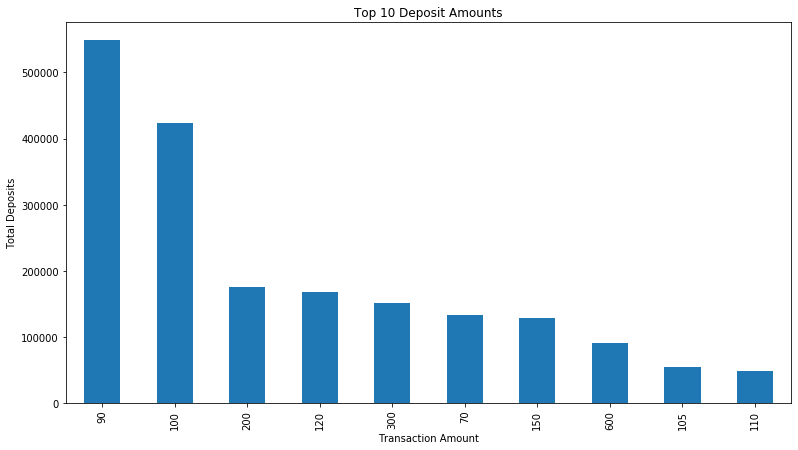

In [144]:
amount.plot(kind='bar')
plt.ylabel('Total Deposits')
plt.title('Top 10 Deposit Amounts')
plt.show()